In [36]:
import networkx as nx
import numpy as np
import os
import time
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from itertools import chain
from collections import defaultdict
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from operator import itemgetter
from networkx.drawing.nx_agraph import graphviz_layout

In [10]:
train_file = "./data/train.csv"
valid_file = "./data/valid.csv"
test_file = "./data/test.csv"

In [6]:
test_file.head()

,src,dst,score
0,58yXn5Y4409kc9q88YwU6w,sD6pnjnciK--3OSdM12FOA,0
1,ipqEcqA1MMWPE9QR4izj-w,nxEZi8hmI5zR_x85sZZJyg,0
2,JPEp9OrW0HLZUQ4t-ODM6w,t8a4wTKqHjF6b_6VqBfr8A,0
3,PcPminF0bIUsKjUh9e4DMQ,dEk7mXM4npuDPmxrwPcEgQ,0
4,9SiMC8YFsAZi1kZ-cyxG6w,Wi0VgIrbb8vqU6weyVw6tg,0


In [11]:
def load_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        user_id, friends = row["user_id"], eval(row["friends"])
        for friend in friends:
            # add each friend relation as an edge
            edges.append((user_id, friend))
    edges = sorted(edges)
    
    return edges

def load_test_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    scores = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        edges.append((row["src"], row["dst"]))
    edges = sorted(edges)
    
    return edges

def generate_false_edges(true_edges, num_false_edges=5):
    """
    generate false edges given true edges
    """
    nodes = list(set(chain.from_iterable(true_edges)))
    N = len(nodes)
    true_edges = set(true_edges)
    print(N, len(true_edges))
    false_edges = set()
    
    while len(false_edges) < num_false_edges:
        # randomly sample two different nodes and check whether the pair exisit or not
        src, dst = nodes[int(np.random.rand() * N)], nodes[int(np.random.rand() * N)]
        if src != dst and (src, dst) not in true_edges and (src, dst) not in false_edges:
            false_edges.add((src, dst))
    false_edges = sorted(false_edges)
    
    return false_edges

def construct_graph_from_edges(edges):
    """
    generate a directed graph object given true edges
    DiGraph documentation: https://networkx.github.io/documentation/stable/reference/classes/digraph.html
    """
    # convert a list of edges {(u, v)} to a list of edges with weights {(u, v, w)}
    edge_weight = defaultdict(float)
    for e in edges:
        edge_weight[e] += 1.0
    weighed_edge_list = list()
    for e in sorted(edge_weight.keys()):
        weighed_edge_list.append((e[0], e[1], edge_weight[e]))
        
    graph = nx.DiGraph()
    graph.add_weighted_edges_from(weighed_edge_list)
    
    print("number of nodes:", graph.number_of_nodes())
    print("number of edges:", graph.number_of_edges())
    
    return graph

In [14]:
train_edges = load_data(train_file)
graph = construct_graph_from_edges(train_edges)
valid_edges = load_data(valid_file)
false_edges = generate_false_edges(train_edges+valid_edges, 40000-len(valid_edges))
test_edges = load_test_data(test_file)

number of nodes: 8328
number of edges: 100000
8474 119268


In [15]:
graph_2 = construct_graph_from_edges(test_edges)

number of nodes: 8509
number of edges: 40000


In [16]:
graph_3 = construct_graph_from_edges(valid_edges)

number of nodes: 5440
number of edges: 19268


In [17]:
G_train = graph
G_test = graph_2 
G_val = graph_3

In [32]:
graphs = [G_train, G_test, G_val]
Name = ['Train Network', 'Test Network', 'Validation Network']

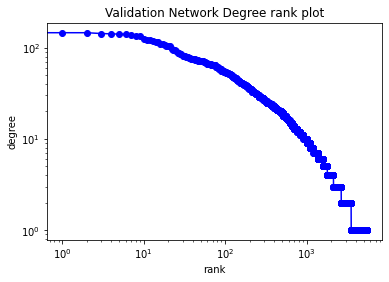

In [50]:
degree_sequence = sorted([d for n, d in G_val.degree()], reverse=True)
dmax = max(degree_sequence)

plt.loglog(degree_sequence, "b-", marker="o")
plt.title("Validation Network Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

# draw graph in inset
plt.axes([0.45, 0.45, 0.45, 0.45])
plt.axis("off")
plt.show()

In [39]:
print('Clustering Coefficients:')
for G in graphs:
    print(nx.average_clustering(G))

Clustering Coefficients:
0.18328889886033992
0.006329380161856736
0.029565832698769303


In [41]:
print('Triadic Census:')
for G in graphs:
    print(nx.triadic_census(G))

Triadic Census:
{'003': 95705285681, '012': 225854476, '102': 293801782, '021D': 267296, '021U': 258416, '021C': 526708, '111D': 1358475, '111U': 1381511, '030T': 21659, '030C': 7261, '201': 1783231, '120D': 28403, '120U': 28690, '120C': 56724, '210': 149368, '300': 65895}
{'003': 102315383154, '012': 315926161, '102': 11352220, '021D': 170502, '021U': 170413, '021C': 341776, '111D': 41060, '111U': 41047, '030T': 4820, '030C': 1613, '201': 2895, '120D': 384, '120U': 416, '120C': 751, '210': 119, '300': 3}
{'003': 26719578470, '012': 89617340, '102': 7022547, '021D': 107390, '021U': 112311, '021C': 219604, '111D': 33924, '111U': 33296, '030T': 4974, '030C': 1667, '201': 2537, '120D': 376, '120U': 361, '120C': 758, '210': 121, '300': 4}


In [44]:
print('transitivity:')
for G in graphs:
    print(nx.transitivity(G))

transitivity:
0.12657438685440273
0.017035552063861873
0.02525830466977586


In [47]:
nx.write_gexf(G_train, "G_train.gexf")
nx.write_gexf(G_test, "G_test.gexf")
nx.write_gexf(G_val, "G_val.gexf")